# Astro Retriever demo

### Create a demo project with the VirtualDemoObs lightcurve simulator

Create a project and choose some parameters. 

In [1]:
from src.project import Project
import src.database
src.database.DATA_ROOT = "data"  # point to local folder


proj = Project(
        name="demo_notebook_project",
        obs_names=["demo"],
        analysis_kwargs={"num_injections": 3},
        obs_kwargs={},
        catalog_kwargs={"default": "test"},
        verbose=6,
    )
proj.delete_all_sources()
print(proj.catalog.data)

Loading catalog from /home/guyn/Dropbox/python/AstroRetriever/catalogs/test.csv
                 object_id          ra        dec        mag    magerr
0  J13:49:13.43-21:12:53.2  207.305941 -21.785213  18.154018  0.144190
1  J04:03:39.73-67:10:51.8   60.915525 -67.818943  17.022696  0.355366
2  J02:17:29.98+07:47:17.0   34.374929   7.788064  15.373511  0.335444
3  J13:21:13.68-23:20:36.1  200.307020 -23.656644  16.144296  0.321342
4  J11:23:55.28-40:02:27.0  170.980316 -40.959164  17.338122  0.429115
5  J00:47:57.85+33:52:36.8   11.991040  33.876896  16.769316  0.347271
6  J11:49:46.80-60:44:54.3  177.444989 -60.251594  19.592982  0.182022
7  J22:30:58.03-07:40:44.8  337.741774  -7.320885  15.686335  0.328349
8  J20:31:09.62+76:24:39.1  307.790075  76.410849  15.722183  0.189884
9  J16:44:55.81-44:56:39.2  251.232531 -44.055785  17.360968  0.160028


In [2]:
proj.run()  # download data, reduce it, run analysis

In [3]:
print(f'Found {len(proj.sources)} sources during this run.')

Found 10 sources during this run.


This is an example source with some data attached to it. 

In [4]:
print(proj.sources[0])

Source(name="J13:49:13.43-21:12:53.2", ra=13:49:13.43, dec=-21:12:53.2, mag= 18.15, project="demo_notebook_project", datasets= 1)


In [5]:
print(proj.sources[0].raw_photometry[0])

RawPhotometry(type=photometry, source=J13:49:13.43-21:12:53.2 (DEMO), epochs=100, file: RA207/DEMO_photometry_J13:49:13.43-21:12:53.2.h5 (key: photometry_J13:49:13.43-21:12:53.2))


In [6]:
print(proj.sources[0].reduced_photometry[0])

Lightcurve(id=57, source=J13:49:13.43-21:12:53.2, epochs=100, reduced, DEMO, mag[R]=17.99±0.10, file: RA207/DEMO_photometry_J13:49:13.43-21:12:53.2_reduced.h5, key: photometry_J13:49:13.43-21:12:53.2_reduction_01_of_01)


We can find the file on disk easily. 

In [7]:
print(proj.sources[0].reduced_photometry[0].get_fullname())

data/DEMO_NOTEBOOK_PROJECT/RA207/DEMO_photometry_J13:49:13.43-21:12:53.2_reduced.h5


In [8]:
!ls data/DEMO_NOTEBOOK_PROJECT/RA207/ -lh

total 2.1M
-rw-rw-r-- 1 guyn guyn 1.1M Mar  7 14:40 DEMO_photometry_J13:49:13.43-21:12:53.2_processed.h5
-rw-rw-r-- 1 guyn guyn 1.1M Mar  7 14:40 DEMO_photometry_J13:49:13.43-21:12:53.2_reduced.h5


In [9]:
print(proj.sources[0].reduced_photometry[0].data)

           time  exptime          ra        dec        mag    magerr filter  \
0   57000.00000       30  207.305783 -21.785179  18.174155  0.105385      R   
1   57010.10101       30  207.305878 -21.785095  17.864243  0.104642      R   
2   57020.20202       30  207.306223 -21.785208  18.044498  0.107521      R   
3   57030.30303       30  207.305879 -21.785277  18.080735  0.105068      R   
4   57040.40404       30  207.306100 -21.785225  18.049273  0.090738      R   
..          ...      ...         ...        ...        ...       ...    ...   
95  57959.59596       30  207.306033 -21.785102  17.981219  0.109448      R   
96  57969.69697       30  207.306053 -21.785116  17.963896  0.101651      R   
97  57979.79798       30  207.306099 -21.785103  17.821964  0.108913      R   
98  57989.89899       30  207.305898 -21.785239  18.137725  0.107502      R   
99  58000.00000       30  207.305860 -21.785311  17.916389  0.096084      R   

     flag        flux    fluxerr        snr      ds

We can query the database for the lightcurves. Note that `lc.data` is lazy loaded from disk automatically. 

In [10]:
import sqlalchemy as sa
from src.database import Session
from src.dataset import Lightcurve

with Session() as session:
    lc = session.scalars(
        sa.select(Lightcurve).where(
            Lightcurve.source_name == proj.sources[0].name, 
            Lightcurve.project == 'demo_notebook_project', 
            Lightcurve.was_processed == False, 
        )
    ).first()

print(f'The data loaded is the same as the data from before: {lc.data.equals(proj.sources[0].reduced_photometry[0].data)}')


The data loaded is the same as the data from before: True


Has some built in tools for plotting, some statistics pre-calculated (and queryable!) 

mag: 17.988983729994324 | std: 0.09871879962334497


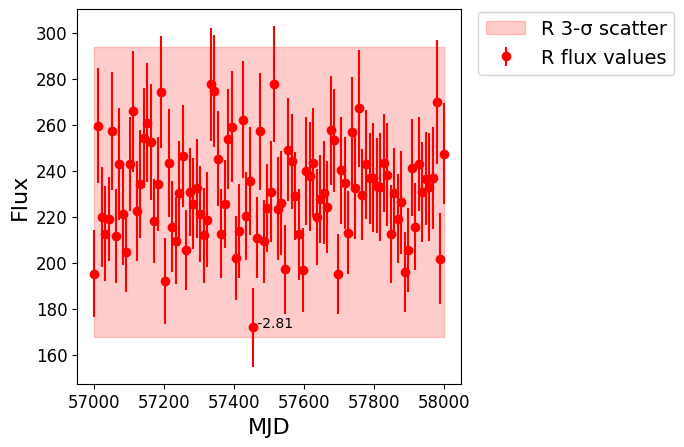

In [11]:
lc.plot(threshold=2.5, ftype='flux')
print(f'mag: {lc.mag_mean} | std: {lc.mag_rms}')

Can find sources based on their coordinates. 

In [12]:
from src.source import Source, cone_search
ra = proj.sources[0].ra
dec = proj.sources[0].dec
with Session() as session:
    source = session.scalars(cone_search(ra, dec).where(Source.project == 'demo_notebook_project')).first()

print(source)
print(f'source names are the same: {source.name == proj.sources[0].name}')

Source(name="J13:49:13.43-21:12:53.2", ra=13:49:13.43, dec=-21:12:53.2, mag= 18.15, project="demo_notebook_project", datasets= 0)
source names are the same: True


### What about downloading real data? 

In [13]:
from src.project import Project
import src.database
src.database.DATA_ROOT = "data"  # point to local folder
proj = Project(name='real_data_demo', obs_names=['ZTF', 'TESS'], catalog_kwargs={'default': 'WD'})
proj.delete_all_sources(remove_associated_data=True, remove_raw_data=True, remove_detections=True)

This project uses the default "WD" catalog to load the white dwarf catalog from [Gentile Fusillo et al 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3877G/abstract)

In [14]:
print(f'Number of white dwarf sources in catalog: {len(proj.catalog.data)}')

Number of white dwarf sources in catalog: 1280266


Choose a bright, easy to find white dwarf in the Northern hemisphere:

In [19]:
import numpy as np
idx = np.where((proj.catalog.data['dec'] > 0) & (proj.catalog.data['phot_g_mean_mag'] < 15))[0][2]
cat_row = proj.catalog.get_row(idx, output='dict')
print(cat_row)

{'cat_index': 4936, 'name': '2868734963397148672', 'ra': 357.03129826380626, 'dec': 32.079995045185086, 'mag': 14.14486026763916, 'mag_err': None, 'mag_filter': 'Gaia_G', 'alias': None, 'pmra': -3.4980221124470257}


Get this object from the ZTF database:

In [20]:
from time import time
t0 = time()
source = proj.ztf.fetch_source(cat_row)
print(f'Fetch took {time()-t0:.1f}s')

Fetch took 8.9s


In [21]:
print(source)
print(f'This source is new or from database: {source.loaded_status}')
print(source.raw_photometry[0])
print(f'This photometry is new or from database: {source.raw_photometry[0].loaded_status}')

Source(name="2868734963397148672", ra=23:48:07.51, dec=+32:04:48.0, mag= 14.14, project="real_data_demo", datasets= 1)
This source is new or from database: new
RawPhotometry(type=photometry, source=2868734963397148672 (ZTF), epochs=2765, file: RA357/ZTF_photometry_2868734963397148672.h5 (key: photometry_2868734963397148672))
This photometry is new or from database: new


What happens if we try to run this again? 

In [22]:
t0 = time()
source = proj.ztf.fetch_source(cat_row)
print(f'Fetch took {time()-t0:.1f}s')

Fetch took 0.3s


In [23]:
print(source)
print(f'This source is new or from database: {source.loaded_status}')
print(source.raw_photometry[0])
print(f'This photometry is new or from database: {source.raw_photometry[0].loaded_status}')

Source(name="2868734963397148672", ra=23:48:07.51, dec=+32:04:48.0, mag= 14.14, project="real_data_demo", datasets= 1)
This source is new or from database: database
RawPhotometry(type=photometry, source=2868734963397148672 (ZTF), epochs=2765, file: RA357/ZTF_photometry_2868734963397148672.h5 (key: photometry_2868734963397148672))
This photometry is new or from database: database


<AxesSubplot: xlabel='MJD', ylabel='Magnitude'>

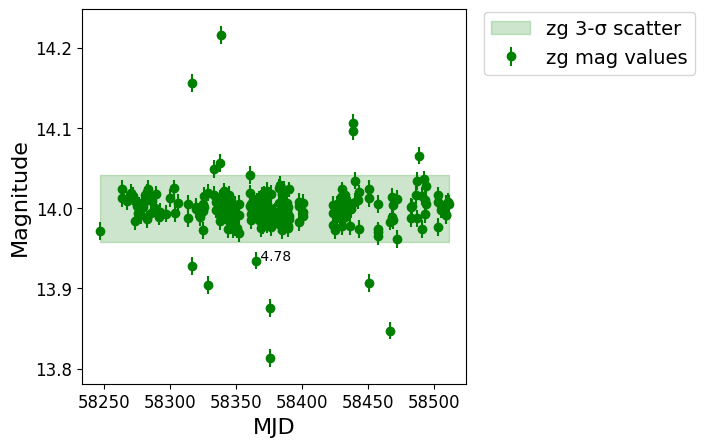

In [24]:
source.reduced_photometry[0].plot(threshold=4.0)

What about TESS data?

In [25]:
t0 = time()
source2 = proj.tess.fetch_source(cat_row)
print(f'Fetch took {time()-t0:.1f}s')

Fetch took 8.2s


In [26]:
print(source2)
print(f'This source is new or from database: {source2.loaded_status}')
print(source2.raw_photometry[0])
print(f'This photometry is new or from database: {source2.raw_photometry[0].loaded_status}')

Source(name="2868734963397148672", ra=23:48:07.51, dec=+32:04:48.0, mag= 14.14, project="real_data_demo", datasets= 1)
This source is new or from database: database
RawPhotometry(type=photometry, source=2868734963397148672 (TESS), epochs=18009, file: RA357/TESS_photometry_2868734963397148672.h5 (key: photometry_2868734963397148672))
This photometry is new or from database: new


In [27]:
print(f'sources are the same: {source.name == source2.name}')

sources are the same: True


Can now get the new TESS data appended easily on the old source:

In [28]:
with Session() as session:
    source.get_data(obs='tess', level='raw', data_type='photometry', session=session)
print(f'Source has raw data from these observatories: {[data.observatory for data in source.raw_photometry]}')

Source has raw data from these observatories: ['ztf', 'tess']


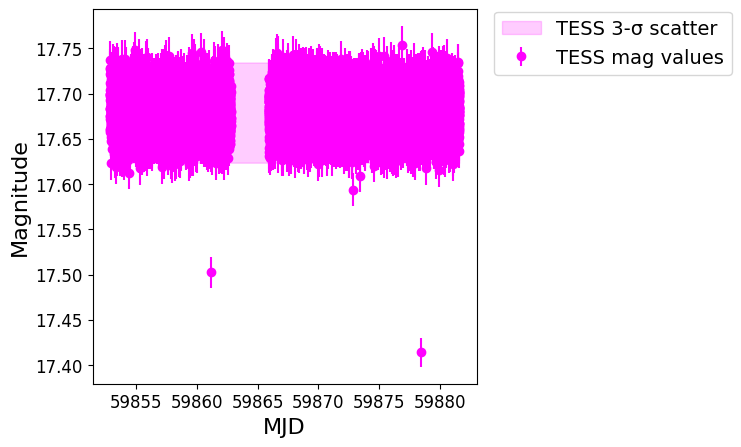

In [30]:
with Session() as session:
    lcs = source.get_data(obs='tess', level='reduced', data_type='photometry', session=session)
    lcs[0].plot()